In [47]:
%matplotlib inline
import os
os.chdir('U:\\GitHubClones\\SALTSeniorDesign')
os.getcwd()
#import Excel
import xlwings as xw
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import re
from datetime import datetime
import datetime
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import time

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [39]:
mapDict = {
    'subvented':{
        0:'None',
        1:'Rate',
        2:'Cash',
        3:'Both',
    },
    'vehicleTypeCode':{
        1:'Car',
        2:'Truck',
        3:'SUV',
        4:'Motorcycle',
        98:'Other',
        99:'Unknown'
    },
    'obligorIncomeVerificationLevelCode':{
        1:'NotStatedNotVerified',
        2:'StatedNotVerified',
        3:'StatedVerified',
        4:'Stated12mVerified',
        5:'Stated24mVerified'
    },
    'obligorEmploymentVerificationCode':{
        1:'NotStatedNotVerified',
        2:'StatedNotVerified',
        3:'StatedVerified'
    }
}

'''
x = list(Dict.keys())
for i in range(0, len(x)):
    data[x[i]] = data[x[i]].map(Dict[x[i]])
data = pd.get_dummies(data, columns= x)
'''
#For creating dummy variables on the fly

'\nx = list(Dict.keys())\nfor i in range(0, len(x)):\n    data[x[i]] = data[x[i]].map(Dict[x[i]])\ndata = pd.get_dummies(data, columns= x)\n'

In [33]:
cols = ['assetNumber', 'reportingPeriodEndingDate','reportingPeriodBeginningDate',
        'originalLoanTerm','originalLoanAmount','vehicleValueAmount','originalInterestRatePercentage','subvented',
        'vehicleNewUsedCode', 'vehicleModelYear','vehicleTypeCode',
        'obligorCreditScore','obligorIncomeVerificationLevelCode', 'obligorEmploymentVerificationCode','obligorGeographicLocation',
        'paymentToIncomePercentage', 'reportingPeriodActualEndBalanceAmount',
        'reportingPeriodBeginningLoanBalanceAmount','totalActualAmountPaid',
        'remainingTermToMaturityNumber',
        'currentDelinquencyStatus','coObligorIndicator',
        'zeroBalanceCode']

logitRemoveCols = ['assetNumber', 'reportingPeriodEndingDate','originalLoanAmount','vehicleValueAmount','reportingPeriodActualEndBalanceAmount',
        'reportingPeriodBeginningLoanBalanceAmount','totalActualAmountPaid','vehicleNewUsedCode','zeroBalanceCode',
        'vehicleModelYear','currentDelinquencyStatus','subvented','obligorIncomeVerificationLevelCode', 'obligorEmploymentVerificationCode',
        'obligorGeographicLocation','reportingPeriodBeginningDate']

In [4]:
wb = xw.Book('Salt.xlsm')
setup = wb.sheets('Setup')
output = wb.sheets('Output')
strats = wb.sheets('Strat Tables')
performance = wb.sheets('Performance')

# Path For the Current deal that is selected based on Setup
directory = setup['Setup.Directory'].value
shelf = setup['Setup.Shelf'].value
deal = setup['Setup.Deal'].value
report = setup['Setup.Report'].value
num_Deals = setup['Setup.Num_Deals'].value
max_Report = setup['Setup.Max_Report_Num'].value

In [5]:
tapes = np.array(setup['Tapes'].value)
tapes = tapes[0:int(max_Report),0:int(num_Deals)]
dfTapes = pd.DataFrame(data=tapes[1:,1:], columns=tapes[0,1:])
dfTapes

,AMCAR 2017-1,AMCAR 2017-2,AMCAR 2017-3,SDART 2017-1,SDART 2017-2,SDART 2017-3
0,2017\01 January\2017.03.23_AmeriCredit Automob...,2017\03 March\2017.05.02_AmeriCredit Automobil...,2017\06 June\2017.07.01_AmeriCredit Automobile...,2017\01 January\2017.02.15_Santander Drive Aut...,2017\04 April\2017.05.18_Santander Drive Auto ...,2017\08 August\2017.09.07_Santander Drive Auto...
1,2017\02 February\2017.03.23_AmeriCredit Automo...,2017\04 April\2017.06.23_AmeriCredit Automobil...,2017\07 July\2017.08.25_AmeriCredit Automobile...,2017\02 February\2017.03.15_Santander Drive Au...,2017\05 May\2017.06.15_Santander Drive Auto Re...,2017\09 September\2017.10.16_Santander Drive A...
2,2017\03 March\2017.04.24_AmeriCredit Automobil...,2017\05 May\2017.07.24_AmeriCredit Automobile ...,2017\08 August\2017.09.25_AmeriCredit Automobi...,2017\03 March\2017.04.17_Santander Drive Auto ...,2017\06 June\2017.07.17_Santander Drive Auto R...,None
3,2017\04 April\2017.05.23_AmeriCredit Automobil...,2017\06 June\2017.08.23_AmeriCredit Automobile...,None,2017\04 April\2017.05.15_Santander Drive Auto ...,2017\07 July\2017.08.15_Santander Drive Auto R...,None
4,2017\05 May\2017.06.23_AmeriCredit Automobile ...,2017\08 August\2017.09.25_AmeriCredit Automobi...,None,2017\05 May\2017.06.15_Santander Drive Auto Re...,2017\08 August\2017.09.15_Santander Drive Auto...,None
5,2017\06 June\2017.07.24_AmeriCredit Automobile...,None,None,2017\06 June\2017.07.17_Santander Drive Auto R...,2017\09 September\2017.10.16_Santander Drive A...,None
6,2017\07 July\2017.08.23_AmeriCredit Automobile...,None,None,2017\07 July\2017.08.15_Santander Drive Auto R...,None,None
7,2017\08 August\2017.09.25_AmeriCredit Automobi...,None,None,2017\08 August\2017.09.15_Santander Drive Auto...,None,None


In [6]:
def unemployment(path):
    umrate = pd.read_csv(path, memory_map=True, low_memory=False)
    umrate['Date'] = pd.to_datetime(umrate.Date)
    umrate['Date'] = umrate['Date'].dt.strftime('%m/%d/%Y')
    umrate = umrate.set_index('Date')
    stateDict = umrate.to_dict(orient='index')
    return stateDict

In [7]:
def chargeOffs(tapes, deal, unemploymentPath):
    dealLis = list(tapes[deal].astype(str))
    dealLis = filter(lambda a: a != 'None', dealLis)
    train = pd.DataFrame()
    for i in range(0, len(dealLis)):
        path = directory + '\\' + shelf + '\\' + deal + '\\' + dealLis[i]
        df = pd.read_csv(path, usecols=cols, memory_map=True, low_memory=False)
        df = df[~df.zeroBalanceCode.isin(['-'])]#taking out all of the performing loans so far
        
        df['LTV'] = (df['originalLoanAmount']/df['vehicleValueAmount'])*100
        df['loanDiff'] = (df['originalLoanAmount'] - df['reportingPeriodBeginningLoanBalanceAmount'])
        df['coObligorIndicator'] = df['coObligorIndicator'].astype(int)
        
        umrate = pd.read_csv(unemploymentPath, memory_map=True, low_memory=False)
        umrate['Date'] = pd.to_datetime(umrate.Date)
        umrate['Date'] = umrate['Date'].dt.strftime('%m/%d/%Y')
        umrate = umrate.set_index('Date')
        stateDict = umrate.to_dict(orient='index')

        df['reportingPeriodBeginningDate'] = pd.to_datetime(df['reportingPeriodBeginningDate']).dt.strftime('%m/%d/%Y')
        states = list(df['obligorGeographicLocation'])
        uniqueList = df.reportingPeriodBeginningDate.unique()
        umList = []
        for j in range(0, len(states)):
            if not uniqueList[0]:
                continue
            val = stateDict[uniqueList[0]].get(states[j])
            umList.append(val)
        unemployment = pd.Series(umList)
        df = df.assign(StateUnemployment=unemployment.values)
        train = train.append(df)
    
    
    return train

In [40]:
umRatePath = 'U:\\GitHubClones\\SALTSeniorDesign\\' + 'State_level_unemployment_rate.csv'
dfTrain = chargeOffs(dfTapes, deal, umRatePath)

In [10]:
dfTrain.head()

,assetNumber,reportingPeriodBeginningDate,reportingPeriodEndingDate,originalLoanAmount,originalLoanTerm,originalInterestRatePercentage,subvented,vehicleNewUsedCode,vehicleModelYear,vehicleTypeCode,vehicleValueAmount,obligorCreditScore,obligorIncomeVerificationLevelCode,obligorEmploymentVerificationCode,coObligorIndicator,paymentToIncomePercentage,obligorGeographicLocation,remainingTermToMaturityNumber,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,totalActualAmountPaid,zeroBalanceCode,currentDelinquencyStatus,LTV,loanDiff,StateUnemployment
186,"=""10421638""",02/01/2017,02-28-2017,25757.50,72,0.1529,0.0,2,2012,2,21650.0,568,2,2,1,0.091469,TX,43,18154.76,0.0,18413.33,1,0,118.972286,7602.74,4.9
191,"=""10421038""",02/01/2017,02-28-2017,17365.00,72,0.1800,0.0,2,2013,1,15925.0,505,2,1,0,0.181373,VT,43,12567.27,0.0,12740.80,1,0,109.042386,4797.73,3.0
245,"=""10630614""",02/01/2017,02-28-2017,15088.99,72,0.2133,0.0,2,2013,1,14625.0,533,2,1,0,0.167298,OH,43,11231.34,0.0,11505.89,1,0,103.172581,3857.65,5.1
283,"=""10629606""",02/01/2017,02-28-2017,29188.00,72,0.1672,0.0,2,2013,1,20875.0,593,2,2,0,0.123994,TX,42,20059.38,0.0,20454.50,1,0,139.822754,9128.62,4.9
394,"=""10646660""",02/01/2017,02-28-2017,21360.45,72,0.1678,1.0,1,2014,2,45761.0,-,2,2,0,0.047583,FL,43,15290.40,0.0,15522.13,1,0,46.678285,6070.05,5.0


In [41]:
def clean(data):
    data['obligorCreditScore'] = data['obligorCreditScore'].replace(['-'], 0)
    data['zeroBalanceCode'] = pd.to_numeric(data['zeroBalanceCode'], errors = 'coerce')
    data['obligorCreditScore'] = pd.to_numeric(data['obligorCreditScore'], errors = 'coerce')
    data['subvented'] = pd.to_numeric(data['subvented'], errors = 'coerce').fillna(3)
    return data

def logitDummyVariables(data):
    
    data['newUsed'] = np.where((data['vehicleNewUsedCode']>1), 1, 0) # 0 means new, 1 means used
    data['subvent'] = np.where((data['subvented']>0), 1, 0)
    data['verifyScore'] = data['obligorIncomeVerificationLevelCode'] + data['obligorEmploymentVerificationCode']
    data['Default'] = np.where((data['zeroBalanceCode'] == 4), 1, 0)
    
    return data

In [42]:
dfTrain = clean(dfTrain)
dfTrain = logitDummyVariables(dfTrain)
dfTrain = dfTrain.drop(logitRemoveCols, axis=1)
dfTrain.head()

,originalLoanTerm,originalInterestRatePercentage,vehicleTypeCode,obligorCreditScore,coObligorIndicator,paymentToIncomePercentage,remainingTermToMaturityNumber,LTV,loanDiff,StateUnemployment,newUsed,subvent,verifyScore,Default
186,72,0.1529,2,568,1,0.091469,43,118.972286,7602.74,4.9,1,0,4,0
191,72,0.1800,1,505,0,0.181373,43,109.042386,4797.73,3.0,1,0,3,0
245,72,0.2133,1,533,0,0.167298,43,103.172581,3857.65,5.1,1,0,3,0
283,72,0.1672,1,593,0,0.123994,42,139.822754,9128.62,4.9,1,0,4,0
394,72,0.1678,2,0,0,0.047583,43,46.678285,6070.05,5.0,0,1,4,0


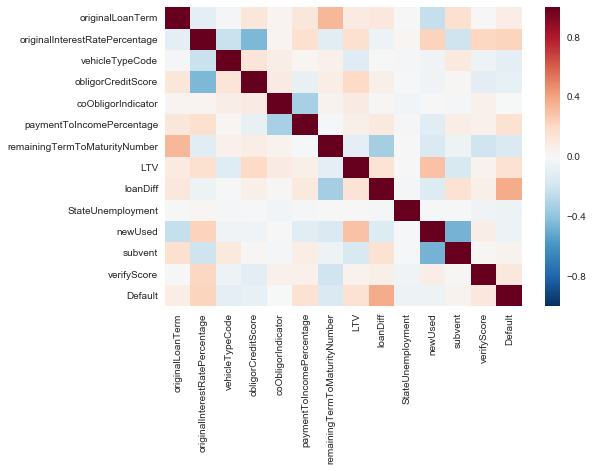

In [43]:
sb.heatmap(dfTrain.corr())

In [44]:
modelCols = list(dfTrain.columns)
modelCols = modelCols[:-1]
predictors = dfTrain[modelCols]
y = dfTrain.Default

In [45]:
est = sm.OLS(y, predictors).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Default   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     752.0
Date:                Wed, 29 Nov 2017   Prob (F-statistic):               0.00
Time:                        19:42:37   Log-Likelihood:                -5667.1
No. Observations:               10104   AIC:                         1.136e+04
Df Residuals:                   10091   BIC:                         1.145e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
originalLoanTerm                  -0.0006      0.001     -0.981      0.327      -0.002       0.001
originalInterestRatePercentage     2.1067      0.112     18.828      0.000       1.887       2.326
vehicleTypeCode                   -0.0314      0.005     -6.086      0.000      -0.042      -0.021
obligorCreditScore             -4.687e-05   2.07e-05     -2.259      0.024   -8.75e-05   -6.21e-06
coObligorIndicator                 0.0002      0.010      0.025      0.980      -0.019       0.020
paymentToIncomePercentage          0.7334      0.115      6.382      0.000       0.508       0.959
remainingTermToMaturityNumber     -0.0001      0.000     -0.396      0.692      -0.001       0.000
LTV                                0.0017      0.000      6.751      0.000       0.001       0.002
loanDiff                        1.824e-05   5.22e-07     34.966      0.000    1.72e-05    1.93e-05
StateUnemployment                 -0.0589      0.006    -10.047      0.000      -0.070      -0.047
newUsed                           -0.0814      0.012     -7.074      0.000      -0.104      -0.059
subvent                           -0.0030      0.018     -0.170      0.865      -0.038       0.032
verifyScore                        0.0052      0.006      0.875      0.382      -0.006       0.017
==============================================================================
Omnibus:                     2201.338   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              788.241
Skew:                           0.489   Prob(JB):                    6.85e-172
Kurtosis:                       2.043   Cond. No.                     3.52e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
logReg = sm.Logit(y,predictors).fit()
logReg.summary()

Optimization terminated successfully.
         Current function value: 0.540232
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                10104
Model:                          Logit   Df Residuals:                    10091
Method:                           MLE   Df Model:                           12
Date:                Wed, 29 Nov 2017   Pseudo R-squ.:                  0.1687
Time:                        19:43:38   Log-Likelihood:                -5458.5
converged:                       True   LL-Null:                       -6566.0
                                        LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
originalLoanTerm                  -0.0187      0.003     -6.018      0.000      -0.025      -0.013
originalInterestRatePercentage    11.1106      0.649     17.128      0.000       9.839      12.382
vehicleTypeCode                   -0.2392      0.030     -8.044      0.000      -0.297      -0.181
obligorCreditScore                -0.0003      0.000     -2.893      0.004      -0.001      -0.000
coObligorIndicator                 0.0041      0.056      0.074      0.941      -0.106       0.114
paymentToIncomePercentage          4.0923      0.638      6.411      0.000       2.841       5.343
remainingTermToMaturityNumber     -0.0023      0.001     -1.705      0.088      -0.005       0.000
LTV                                0.0091      0.001      6.413      0.000       0.006       0.012
loanDiff                        9.043e-05   3.01e-06     30.070      0.000    8.45e-05    9.63e-05
StateUnemployment                 -0.4657      0.033    -14.025      0.000      -0.531      -0.401
newUsed                           -0.5596      0.065     -8.638      0.000      -0.687      -0.433
subvent                           -0.0711      0.100     -0.709      0.478      -0.268       0.125
verifyScore                       -0.0878      0.032     -2.709      0.007      -0.151      -0.024
==================================================================================================
"""

In [ ]:
dfForest = chargeOffs(dfTapes, deal, umRatePath)
dfForest = clean(dfForest)